# Health effects of temperature change (is now indicator 1.2 in 2018 edition)

## Countries
1.1 (->1.2)

- Brazil

OLD:

- USA
- India
- France

## Output


Excel spreadsheet: Columns -> countries, Rows -> years

Generate plots anyways

Generate maps


In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

from tqdm import tqdm_notebook

import population_tools

from config import (DATA_SRC, POP_DATA_SRC)

In [2]:
MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2018/countries/1.1 temperature')

COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/countries_rasters/country_*.nc'

# LIMIT to the following countries for now
SELECTED_COUNTRIES = ['AU', 'BR', 'CA', 'CN', 'DE', 'ES', 'EU', 'FR', 'GB','IN', 'SE', 'US', 'NL', 'PL']
SELECTED_COUNTRIES.sort()

### Load country data

In [3]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))

In [4]:
COUNTRIES_NAMES = COUNTRIES.set_index('iso_a2').sovereignt
COUNTRIES_NAMES['EU'] = 'EU28'

In [5]:
COUNTRIES_RASTER = xr.open_mfdataset(str(COUNTRY_RASTER_FILES))

### Load the temperature anomaly data

In [6]:
# Load the anomaly raster
summer_anom = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_global.nc'))

In [7]:
# Load the global anomaly values
summer_anom_ts = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_global_ts.nc'))
summer_exposures_ts = xr.open_dataarray(str(DATA_SRC /'lancet' / 'summer_exposure_ts.nc'))

In [8]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(summer_anom.latitude))
summer_anom_ts = (summer_anom.sel(year=slice('2000','2016')) * cos_lat).mean(dim=['latitude', 'longitude'])

## Mask the inputs by the country raster files

In [9]:
results = []
for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
    country_mask = COUNTRIES_RASTER.sel(iso_a2=iso_a2).country_mask.load().drop('iso_a2')
    country_exposures_ts = population_tools.project_to_population(summer_anom,
                                                                  weights=country_mask,
                                                                  norm=True, 
                                                                  end_year=MAX_YEAR)
    
    results.append(country_exposures_ts.to_dataframe(iso_a2))
    
results = pd.concat(results,axis=1)

In [10]:
global_reference = pd.concat([summer_exposures_ts.to_dataframe('Mean exposure weighted change (Summer)'),
                              summer_anom_ts.to_dataframe('Mean global change (Summer)')], axis=1)

In [11]:
with pd.ExcelWriter(RESULTS_FOLDER / 'exposure_weighted_summer_temperature_change.xlsx') as writer:
    results.to_excel(writer, sheet_name='exposure change by country')
    global_reference.to_excel(writer, sheet_name='global reference')

### Plots

In [12]:
ANOM_PLOTS = RESULTS_FOLDER / 'anom_plots'
ANOM_PLOTS.mkdir(exist_ok=True)

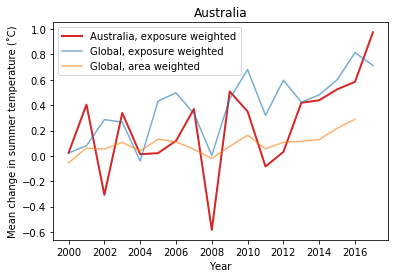

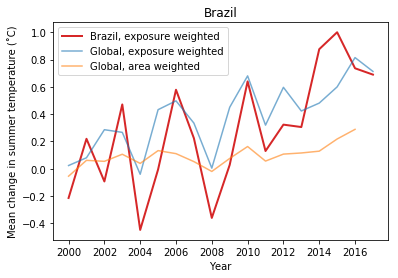

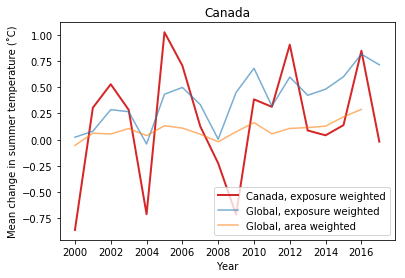

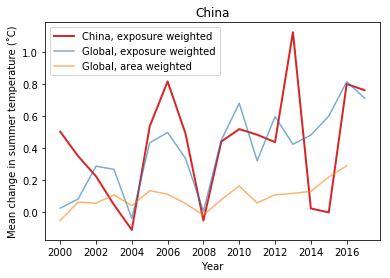

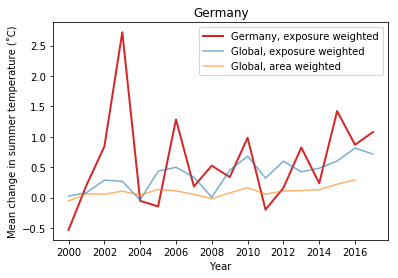

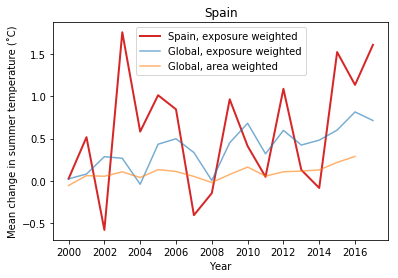

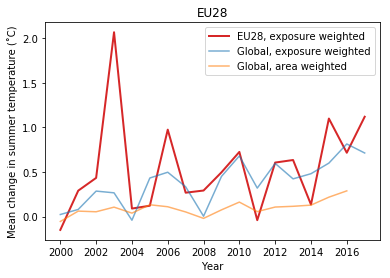

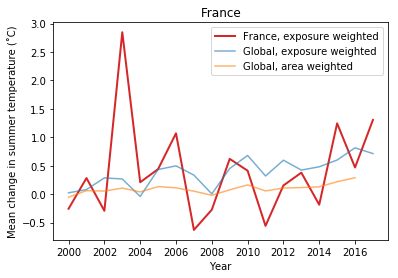

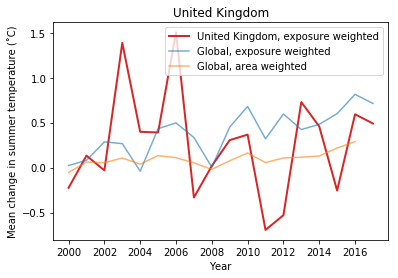

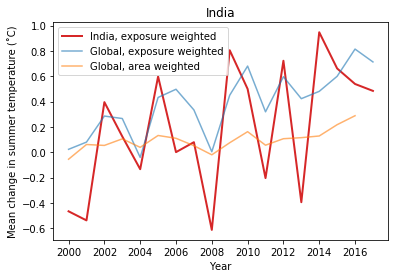

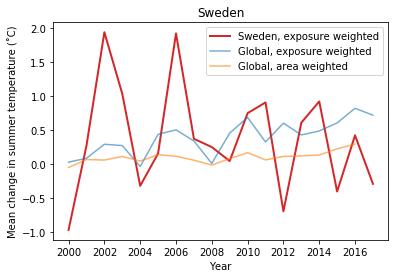

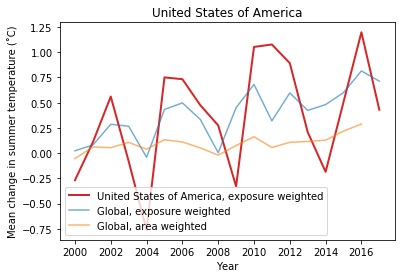

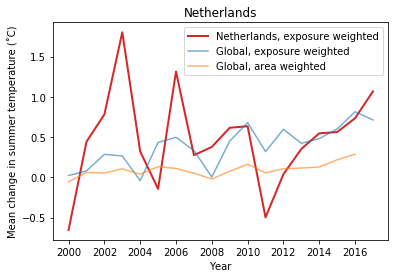

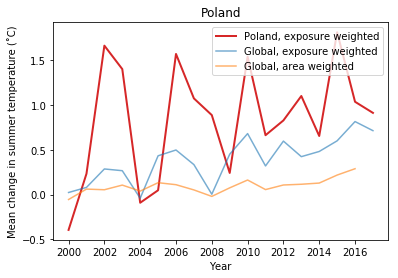

In [13]:
# tmp = countries.set_index('iso_a2')
for h in results:
    
    country_name = COUNTRIES_NAMES[h]
    
    f, ax = plt.subplots()
    results[h].plot(color='C3', 
                           linewidth=2,
                           ax=ax,legend=False,
                           label=f'{country_name}, exposure weighted')
    summer_exposures_ts.plot(color='C0',
                            alpha=0.6,
                            label='Global, exposure weighted', 
                            ax=ax)
    summer_anom_ts.plot(color='C1',
                              alpha=0.6,
                              label='Global, area weighted',
                              ax=ax)

    ax.set_xlabel('Year')
    ax.set_ylabel('''Mean change in summer temperature (˚C)''')
    ax.set_title(f'{country_name}')
    plt.legend()
    plt.xticks(results.index[0::2])
    
    f.savefig(ANOM_PLOTS / f'{h}_summer_temperature_change.png', 
              dpi=300, bbox_inches='tight')



